In [5]:
#!/usr/bin/env python 
# -*- coding: utf-8 -*- 
# @Time : 2020/8/16 11:31 
# @Author : magician 
# @File : a_scores_card_copy.py 
# @Software: PyCharm
import datetime
import re
import time
import numpy as np
import pandas as pd
from dateutil.relativedelta import relativedelta
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")

## 第一步：数据预处理
包括数据分析、观察，针对异常值、缺失值、数据格式的转化进行一个处理。

In [6]:
# 数据预处理
# 1，读入数据
# 2，选择合适的建模样本
# 3，数据集划分成训练集和测试集
allData = pd.read_csv('application.csv',header = 0, encoding = 'latin1')
# print(allData.head(5))
allData['term']=allData['term'].apply(lambda x:int(x.replace(" months","")))
allData['y']=allData['loan_status'].apply(lambda x:int(x=="Charged Off"))

'''
由于存在不同的贷款期限（term），申请评分卡模型评估的违约概率必须要在统一的期限中，且不宜太长，所以选取term＝36months的行本
'''
allData1 = allData.loc[allData.term == 36]
trainData, testData = train_test_split(allData, test_size=0.4)

### 数据预处理阶段定义一些数据转化的函数
CareerYear(x)：#对工作年限进行转换  

DescExisting(x):#将desc变量转换成有记录和无记录两种

ConvertDateStr(x)：转化日期格式

MonthGap():计算时间相差的月份

In [7]:
def CareerYear(x):
    # print(x)
    #对工作年限进行转换
    if x.find('nan') > -1:
        return -1
    elif x.find("10+")>-1:   #将"10＋years"转换成 11
        return 11
    elif x.find('< 1') > -1:  #将"< 1 year"转换成 0
        return 0
    else:
        return re.sub("\D", "", x)  #其余数据，去掉"years"并转换成整数
def DescExisting(x):
    #将desc变量转换成有记录和无记录两种
    if type(x).__name__ == 'float':#针对nan数据的处理方法。这是智能通过数据类型来准确的判断nan
        return 'no desc'
    else:
        return 'desc'
def ConvertDateStr(x,format):
    if str(x) == 'nan':
        return datetime.datetime.strptime('9900-1','%Y-%m')
    else:
        return datetime.datetime.strptime(x,format)
def MakeupMissing(x):
    if np.isnan(x):#判断一个元素是否是nan的方法
        return -1
    else:
        return x

In [8]:
'''
第一步：数据预处理，包括
（1）数据清洗
（2）格式转换
（3）确实值填补
'''
# 将带％的百分比变为浮点数
trainData['int_rate_clean'] = trainData['int_rate'].map(lambda x: float(x.replace('%',''))/100)

# 将工作年限进行转化，否则影响排序
trainData['emp_length_clean'] = trainData['emp_length'].astype(str).map(CareerYear)
trainData['emp_length_clean']=trainData['emp_length_clean'].astype(int)

# 将desc的缺失作为一种状态，非缺失作为另一种状态
trainData['desc_clean'] = trainData['desc'].map(DescExisting)

# 处理日期。earliest_cr_line的格式不统一，需要统一格式且转换成python的日期
trainData['app_date_clean'] = trainData['issue_d'].map(lambda x: ConvertDateStr(x,'%Y/%m/%d'))
trainData['earliest_cr_line_clean'] = trainData['earliest_cr_line'].map(lambda x: ConvertDateStr(x,'%Y/%m/%d'))

# 处理mths_since_last_delinq。注意原始值中有0，所以用－1代替缺失
trainData['mths_since_last_delinq_clean'] = trainData['mths_since_last_delinq'].map(lambda x:MakeupMissing(x))
trainData['mths_since_last_record_clean'] = trainData['mths_since_last_record'].map(lambda x:MakeupMissing(x))
trainData['pub_rec_bankruptcies_clean'] = trainData['pub_rec_bankruptcies'].map(lambda x:MakeupMissing(x))

## 第二步：变量衍生

In [10]:
def MonthGap(earlyDate, lateDate):
    if lateDate > earlyDate:
        #计算相差的月份
        gap = relativedelta(lateDate,earlyDate)
        yr = gap.years
        mth = gap.months
        return yr*12+mth
    else:
        return 0

In [11]:
'''
第二步：变量衍生
'''
# 考虑申请额度与收入的占比
trainData['limit_income'] = trainData.apply(lambda x: x.loan_amnt / x.annual_inc, axis = 1)
# 考虑earliest_cr_line到申请日期的跨度，以月份记
trainData['earliest_cr_to_app'] = trainData.apply(lambda x: MonthGap(x.earliest_cr_line_clean,x.app_date_clean), axis = 1)

### BinBadRate

In [18]:
#计算特征的坏样本率！
def BinBadRate(df, col, target, grantRateIndicator=0):
    '''   
    :param df: 需要计算好坏比率的数据集
    :param col: 需要计算好坏比率的特征
    :param target: 好坏标签
    :param grantRateIndicator: 1返回总体的坏样本率，0不返回
    :return: 每箱的坏样本率，以及总体的坏样本率（当grantRateIndicator＝＝1时）
    '''
    #groupby()[]：只是为了选择【】中的列属性而已
    total = df.groupby([col])[target].count()
    #生成一个DF
    total = pd.DataFrame({'total': total})
    """
    home_ownership
    MORTGAGE    7192
    NONE           3
    OTHER         64
    OWN         1375
    RENT        8823
    Name: y, dtype: int64
    """
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    #将两个df进行left join操作，将左右索引作为连接条件。
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    #统计坏账率：因为在预处理的时候就将数据转化为0、1模式。
    regroup['bad_rate'] = regroup.apply(lambda x: x.bad * 1.0 / x.total, axis=1)
    """
    regroup
 home_ownership  total   bad  bad_rate
    0       MORTGAGE   7192   686  0.095384
    1           NONE      3     0  0.000000
    2          OTHER     64    10  0.156250
    3            OWN   1375   142  0.103273
    4           RENT   8823  1088  0.123314
    """
    #zip():返回一个包含tuple的list，在这里也就是（col，bad_rate）的tuple列表
    
    dicts = dict(zip(regroup[col],regroup['bad_rate']))
    
    # print(dicts)
    """
    {'MORTGAGE': 0.09538375973303671, 'NONE': 0.0, 'OTHER': 0.15625, 'OWN': 0.10327272727272727, 'RENT': 0.1233140655105973}
    """
    # print(dicts)
    if grantRateIndicator==0:
        return (dicts, regroup)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    overallRate = B * 1.0 / N
    return (dicts, regroup, overallRate)

### MergeBad0

In [19]:
#合并特征中坏样本率为0的不同值
def MergeBad0(df,col,target, direction='bad'):
    '''
     :param df: 包含检验0％或者100%坏样本率
     :param col: 分箱后的变量或者类别型变量。检验其中是否有一组或者多组没有坏样本或者没有好样本。如果是，则需要进行合并
     :param target: 目标变量，0、1表示好、坏
     :return: 合并方案，使得每个组里同时包含好坏样本
     '''
    regroup = BinBadRate(df, col, target)[1]#【1】代表得到返回的第二个值
    if direction == 'bad':
        # 如果是合并0坏样本率的组，则跟最小的非0坏样本率的组进行合并
        regroup = regroup.sort_values(by  = 'bad_rate')
    else:
        # 如果是合并0好样本样本率的组，则跟最小的非0好样本率的组进行合并
        regroup = regroup.sort_values(by='bad_rate',ascending=False)
    #regroup.shape[0]:拿到shape方法返回的第一个值即行数。注意【i】表达形式的含义
    regroup.index = range(regroup.shape[0])
    #将列数性col中的值转化为一个list
    col_regroup = [[i] for i in regroup[col]]
    # print col_regroup
    """
    col_regroup
[['NONE'], ['MORTGAGE'], ['OWN'], ['RENT'], ['OTHER']]
    """
    del_index = []
    for i in range(regroup.shape[0]-1):
        col_regroup[i+1] = col_regroup[i] + col_regroup[i+1]
        del_index.append(i)
        if direction == 'bad':
            if regroup['bad_rate'][i+1] > 0:
                break
        else:
            if regroup['bad_rate'][i+1] < 1:
                break
    # print col_regroup
    col_regroup2 = [col_regroup[i] for i in range(len(col_regroup)) if i not in del_index]
    # print "col 2"
    # print col_regroup2
    newGroup = {}
    for i in range(len(col_regroup2)):
        for g2 in col_regroup2[i]:
            newGroup[g2] = 'Bin '+str(i)
#     print "*"*50
#     print newGroup
    """
    newGroup
    **************************************************
{'NONE': 'Bin 0', 'MORTGAGE': 'Bin 0', 'OWN': 'Bin 1', 'RENT': 'Bin 2', 'OTHER': 'Bin 3'}
    """
    return newGroup

### BadRateEncoding
#返回值badRateEnconding：为特征中每个值的坏样本率，bad_rate：对应的dict，k为特征值的名称，v为坏样本率


In [20]:
#坏样本的编码（实质就是将坏样本率赋予对应的值）
def BadRateEncoding(df, col, target):
    '''
    :param df: dataframe containing feature and target
    :param col: the feature that needs to be encoded with bad rate, usually categorical type
    :param target: good/bad indicator
    :return: the assigned bad rate to encode the categorical feature
    '''
    regroup = BinBadRate(df, col, target, grantRateIndicator=0)[1]
    br_dict = regroup[[col,'bad_rate']].set_index([col]).to_dict(orient='index')
    for k, v in br_dict.items():
        br_dict[k] = v['bad_rate']
    badRateEnconding = df[col].map(lambda x: br_dict[x])
    return {'encoding':badRateEnconding, 'bad_rate':br_dict}

### AssignGroup

In [21]:
#样本按箱的划分规则进行分组
def AssignGroup(x, bin):
    '''
    :param x: 某个变量的某个取值
    :param bin: 上述变量的分箱结果
    :return: x在分箱结果下的映射
    '''
    N = len(bin)
    if x<=min(bin):
        return min(bin)
    elif x>max(bin):
        return 10e10
    else:
        for i in range(N-1):
            if bin[i] < x <= bin[i+1]:
                return bin[i+1]

### AssignBin

In [22]:
#执行分箱的操作，先将样本转化为带有标记的分箱结果，后续再进行实际的分箱
def AssignBin(x, cutOffPoints,special_attribute=[]):
    '''
    :param x: 某个变量的某个取值
    :param cutOffPoints: 上述变量的分箱结果，用切分点表示
    :param special_attribute:  不参与分箱的特殊取值
    :return: 分箱后的对应的第几个箱，从0开始
    for example, if cutOffPoints = [10,20,30], if x = 7, return Bin 0. If x = 35, return Bin 3
    '''
    numBin = len(cutOffPoints) + 1 + len(special_attribute)
    if x in special_attribute:
        i = special_attribute.index(x)+1
        return 'Bin {}'.format(0-i)
    if x<=cutOffPoints[0]:
        return 'Bin 0'
    elif x > cutOffPoints[-1]:
        return 'Bin {}'.format(numBin-1)
    else:
        for i in range(0,numBin-1):
            if cutOffPoints[i] < x <=  cutOffPoints[i+1]:
                return 'Bin {}'.format(i+1)

### SplitData
年收入属性的返回值：

[14000.0, 17000.0, 19200.0, 21000.0, 23000.0, 24000.0, 25000.0, 26004.0, 27600.0, 28800.0, 30000.0, 31577.0, 32400.0, 33600.0, 34560.0, 35000.0, 35352.0, 36000.0, 36200.0, 37440.0, 38004.0, 39000.0, 40000.0, 41000.0, 42000.0, 43000.0, 44000.0, 45000.0, 45600.0, 46999.0, 48000.0, 49000.0, 50000.0, 50700.0, 51996.0, 52000.0, 53292.0, 54000.0, 55000.0, 56000.0, 57240.0, 58000.0, 60000.0, 61000.0, 62000.0, 63000.0, 64500.0, 65000.0, 66352.0, 68000.0, 69500.0, 70000.0, 72000.0, 72100.0, 74400.0, 75000.0, 77000.0, 78000.0, 80000.0, 82000.0, 84000.0, 85000.0, 87000.0, 90000.0, 92004.0, 95000.0, 97000.0, 100000.0, 104004.0, 108000.0, 110000.0, 115000.0, 120000.0, 123000.0, 130000.0, 135000.0, 144000.0, 154000.0, 174000.0, 200000.0]


In [30]:
def SplitData(df, col, numOfSplit, special_attribute=[]):
    '''
    :param df: 按照col排序后的数据集
    :param col: 待分箱的变量
    :param numOfSplit: 切分的组别数
    :param special_attribute: 在切分数据集的时候，某些特殊值需要排除在外
    :return: 在原数据集上增加一列，把原始细粒度的col重新划分成粗粒度的值，便于分箱中的合并处理
    '''
    df2 = df.copy()
    if special_attribute != []:
        df2 = df.loc[~df[col].isin(special_attribute)]
    N = df2.shape[0]
    n = int(N/numOfSplit)
    splitPointIndex = [i*n for i in range(1,numOfSplit)]
    # print splitPointIndex
    rawValues = sorted(list(df2[col]))
    # print rawValues
    splitPoint = [rawValues[i] for i in splitPointIndex]
    # print splitPoint
    splitPoint = sorted(list(set(splitPoint)))
    # print (len(splitPoint))
    return splitPoint


### Chi2

In [31]:
#计算卡方值
def Chi2(df, total_col, bad_col, overallRate):
    '''
    :param df: 包含全部样本总计与坏样本总计的数据框
    :param total_col: 全部样本的个数
    :param bad_col: 坏样本的个数
    :param overallRate: 全体样本的坏样本占比
    :return: 卡方值
    '''
    df2 = df.copy()
    # 期望坏样本个数＝全部样本个数*平均坏样本占比
    df2['expected'] = df[total_col].apply(lambda x: x*overallRate)
    combined = zip(df2['expected'], df2[bad_col])
    chi = [(i[0]-i[1])**2/i[0] for i in combined]
    chi2 = sum(chi)
    return chi2

### ChiMerge

In [32]:
#卡方分箱法
### ChiMerge_MaxInterval: split the continuous variable using Chi-square value by specifying the max number of intervals
def ChiMerge(df, col, target, max_interval=5,special_attribute=[],minBinPcnt=0):
    '''
    :param df: 包含目标变量与分箱属性的数据框
    :param col: 需要分箱的属性
    :param target: 目标变量，取值0或1
    :param max_interval: 最大分箱数。如果原始属性的取值个数低于该参数，不执行这段函数
    :param special_attribute: 不参与分箱的属性取值
    :param minBinPcnt：最小箱的占比，默认为0
    :return: 分箱结果
    '''
    colLevels = sorted(list(set(df[col])))
    N_distinct = len(colLevels)
    if N_distinct <= max_interval:  #如果原始属性的取值个数低于max_interval，不执行这段函数
        print ("The number of original levels for {} is less than or equal to max intervals".format(col))
        return colLevels[:-1]
    else:
        if len(special_attribute)>=1:
            df1 = df.loc[df[col].isin(special_attribute)]
            df2 = df.loc[~df[col].isin(special_attribute)]
        else:
            df2 = df.copy()
        N_distinct = len(list(set(df2[col])))

        # 步骤一: 通过col对数据集进行分组，求出每组的总样本数与坏样本数
        if N_distinct > 100:
            split_x = SplitData(df2, col, 100)
            # print "*"*100
            # print split_x
            df2['temp'] = df2[col].map(lambda x: AssignGroup(x, split_x))
        else:
            df2['temp'] = df2[col]
        # 总体bad rate将被用来计算expected bad count
        (binBadRate, regroup, overallRate) = BinBadRate(df2, 'temp', target, grantRateIndicator=1)

        # 首先，每个单独的属性值将被分为单独的一组
        # 对属性值进行排序，然后两两组别进行合并
        colLevels = sorted(list(set(df2['temp'])))
        groupIntervals = [[i] for i in colLevels]

        # 步骤二：建立循环，不断合并最优的相邻两个组别，直到：
        # 1，最终分裂出来的分箱数<＝预设的最大分箱数
        # 2，每箱的占比不低于预设值（可选）
        # 3，每箱同时包含好坏样本
        # 如果有特殊属性，那么最终分裂出来的分箱数＝预设的最大分箱数－特殊属性的个数
        split_intervals = max_interval - len(special_attribute)
        while (len(groupIntervals) > split_intervals):  # 终止条件: 当前分箱数＝预设的分箱数
            # 每次循环时, 计算合并相邻组别后的卡方值。具有最小卡方值的合并方案，是最优方案
            chisqList = []
            for k in range(len(groupIntervals)-1):
                temp_group = groupIntervals[k] + groupIntervals[k+1]
                df2b = regroup.loc[regroup['temp'].isin(temp_group)]
                chisq = Chi2(df2b, 'total', 'bad', overallRate)
                chisqList.append(chisq)
            best_comnbined = chisqList.index(min(chisqList))
            groupIntervals[best_comnbined] = groupIntervals[best_comnbined] + groupIntervals[best_comnbined+1]
            # after combining two intervals, we need to remove one of them
            groupIntervals.remove(groupIntervals[best_comnbined+1])
        groupIntervals = [sorted(i) for i in groupIntervals]
        cutOffPoints = [max(i) for i in groupIntervals[:-1]]

        # 检查是否有箱没有好或者坏样本。如果有，需要跟相邻的箱进行合并，直到每箱同时包含好坏样本
        groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
        df2['temp_Bin'] = groupedvalues
        (binBadRate,regroup) = BinBadRate(df2, 'temp_Bin', target)
        [minBadRate, maxBadRate] = [min(binBadRate.values()),max(binBadRate.values())]
        while minBadRate ==0 or maxBadRate == 1:
            # 找出全部为好／坏样本的箱
            indexForBad01 = regroup[regroup['bad_rate'].isin([0,1])].temp_Bin.tolist()
            bin=indexForBad01[0]
            # 如果是最后一箱，则需要和上一个箱进行合并，也就意味着分裂点cutOffPoints中的最后一个需要移除
            if bin == max(regroup.temp_Bin):
                cutOffPoints = cutOffPoints[:-1]
            # 如果是第一箱，则需要和下一个箱进行合并，也就意味着分裂点cutOffPoints中的第一个需要移除
            elif bin == min(regroup.temp_Bin):
                cutOffPoints = cutOffPoints[1:]
            # 如果是中间的某一箱，则需要和前后中的一个箱进行合并，依据是较小的卡方值
            else:
                # 和前一箱进行合并，并且计算卡方值
                currentIndex = list(regroup.temp_Bin).index(bin)
                prevIndex = list(regroup.temp_Bin)[currentIndex - 1]
                df3 = df2.loc[df2['temp_Bin'].isin([prevIndex, bin])]
                (binBadRate, df2b) = BinBadRate(df3, 'temp_Bin', target)
                chisq1 = Chi2(df2b, 'total', 'bad', overallRate)
                # 和后一箱进行合并，并且计算卡方值
                laterIndex = list(regroup.temp_Bin)[currentIndex + 1]
                df3b = df2.loc[df2['temp_Bin'].isin([laterIndex, bin])]
                (binBadRate, df2b) = BinBadRate(df3b, 'temp_Bin', target)
                chisq2 = Chi2(df2b, 'total', 'bad', overallRate)
                if chisq1 < chisq2:
                    cutOffPoints.remove(cutOffPoints[currentIndex - 1])
                else:
                    cutOffPoints.remove(cutOffPoints[currentIndex])
            # 完成合并之后，需要再次计算新的分箱准则下，每箱是否同时包含好坏样本
            groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
            df2['temp_Bin'] = groupedvalues
            (binBadRate, regroup) = BinBadRate(df2, 'temp_Bin', target)
            [minBadRate, maxBadRate] = [min(binBadRate.values()), max(binBadRate.values())]
        # 需要检查分箱后的最小占比
        if minBinPcnt > 0:
            groupedvalues = df2['temp'].apply(lambda x: AssignBin(x, cutOffPoints))
            df2['temp_Bin'] = groupedvalues
            valueCounts = groupedvalues.value_counts().to_frame()
            valueCounts['pcnt'] = valueCounts['temp'].apply(lambda x: x * 1.0 / N)
            valueCounts = valueCounts.sort_index()
            minPcnt = min(valueCounts['pcnt'])
            while minPcnt < minBinPcnt and len(cutOffPoints) > 2:
                # 找出占比最小的箱
                indexForMinPcnt = valueCounts[valueCounts['pcnt'] == minPcnt].index.tolist()[0]
                # 如果占比最小的箱是最后一箱，则需要和上一个箱进行合并，也就意味着分裂点cutOffPoints中的最后一个需要移除
                if indexForMinPcnt == max(valueCounts.index):
                    cutOffPoints = cutOffPoints[:-1]
                # 如果占比最小的箱是第一箱，则需要和下一个箱进行合并，也就意味着分裂点cutOffPoints中的第一个需要移除
                elif indexForMinPcnt == min(valueCounts.index):
                    cutOffPoints = cutOffPoints[1:]
                # 如果占比最小的箱是中间的某一箱，则需要和前后中的一个箱进行合并，依据是较小的卡方值
                else:
                    # 和前一箱进行合并，并且计算卡方值
                    currentIndex = list(valueCounts.index).index(indexForMinPcnt)
                    prevIndex = list(valueCounts.index)[currentIndex - 1]
                    df3 = df2.loc[df2['temp_Bin'].isin([prevIndex, indexForMinPcnt])]
                    (binBadRate, df2b) = BinBadRate(df3, 'temp_Bin', target)
                    chisq1 = Chi2(df2b, 'total', 'bad', overallRate)
                    # 和后一箱进行合并，并且计算卡方值
                    laterIndex = list(valueCounts.index)[currentIndex + 1]
                    df3b = df2.loc[df2['temp_Bin'].isin([laterIndex, indexForMinPcnt])]
                    (binBadRate, df2b) = BinBadRate(df3b, 'temp_Bin', target)
                    chisq2 = Chi2(df2b, 'total', 'bad', overallRate)
                    if chisq1 < chisq2:
                        cutOffPoints.remove(cutOffPoints[currentIndex - 1])
                    else:
                        cutOffPoints.remove(cutOffPoints[currentIndex])
        cutOffPoints = special_attribute + cutOffPoints
        return cutOffPoints

In [33]:
## 判断某变量的坏样本率是否单调
def BadRateMonotone(df, sortByVar, target,special_attribute = []):
    '''
    :param df: 包含检验坏样本率的变量，和目标变量
    :param sortByVar: 需要检验坏样本率的变量
    :param target: 目标变量，0、1表示好、坏
    :param special_attribute: 不参与检验的特殊值
    :return: 坏样本率单调与否
    '''
    df2 = df.loc[~df[sortByVar].isin(special_attribute)]
    if len(set(df2[sortByVar])) <= 2:
        return True
    regroup = BinBadRate(df2, sortByVar, target)[1]
    combined = zip(regroup['total'],regroup['bad'])
    badRate = [x[1]*1.0/x[0] for x in combined]
    badRateNotMonotone = [badRate[i]<badRate[i+1] and badRate[i] < badRate[i-1] or badRate[i]>badRate[i+1] and badRate[i] > badRate[i-1]
                       for i in range(1,len(badRate)-1)]
    if True in badRateNotMonotone:
        return False
    else:
        return True

## 第三步：分箱即变量离散化
'''
第三步：分箱，采用ChiMerge,要求分箱完之后：

（1）不超过5箱

（2）Bad Rate单调

（3）每箱同时包含好坏样本

（4）特殊值如－1，单独成一箱

连续型变量可直接分箱

类别型变量：

（a）当取值较多时，先用bad rate编码，再用连续型分箱的方式进行分箱

（b）当取值较少时：
    
    （b1）如果每种类别同时包含好坏样本，无需分箱
    
    （b2）如果有类别只包含好坏样本的一种，需要合并
'''


In [34]:

#连续型的变量
num_features = ['int_rate_clean','emp_length_clean','annual_inc', 'dti', 'delinq_2yrs', 'earliest_cr_to_app','inq_last_6mths', \
                'mths_since_last_record_clean', 'mths_since_last_delinq_clean','open_acc','pub_rec','total_acc']
#离散型的变量
cat_features = ['home_ownership', 'verification_status','desc_clean', 'purpose', 'zip_code','addr_state','pub_rec_bankruptcies_clean']


more_value_features = []
less_value_features = []
# 第一步，检查类别型变量中，哪些变量取值超过5
# 第一步，检查类别型变量中，哪些变量取值超过5
for var in cat_features:
    #set：集合（不包含重复的元素）
    valueCounts = len(set(trainData[var]))
    # print (valueCounts)
    if valueCounts > 5:
        more_value_features.append(var)  #取值超过5的变量，需要bad rate编码，再用卡方分箱法进行分箱
    else:
        less_value_features.append(var)


# （i）当取值<5时：如果每种类别同时包含好坏样本，无需分箱；如果有类别只包含好坏样本的一种，需要合并
merge_bin_dict = {}  #存放需要合并的变量，以及合并方法
var_bin_list = []   #由于某个取值没有好或者坏样本而需要合并的变量
for col in less_value_features:
    #先统计less_value_features中各个feature的坏样本率
    binBadRate = BinBadRate(trainData, col, 'y')[0]#这个【0】代表取返回的多个变量中的第一个变量即对应的col的每个值的badrate
    if min(binBadRate.values()) == 0 :  #由于某个取值没有坏样本，则需要进行合并
        print ('{} need to be combined due to 0 bad rate'.format(col))
        combine_bin = MergeBad0(trainData, col, 'y')
        merge_bin_dict[col] = combine_bin
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(combine_bin)
        var_bin_list.append(newVar)
    if max(binBadRate.values()) == 1:    #由于某个取值没有好样本而进行合并
        print ('{} need to be combined due to 0 good rate'.format(col))
        combine_bin = MergeBad0(trainData, col, 'y',direction = 'good')
        merge_bin_dict[col] = combine_bin
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(combine_bin)
        var_bin_list.append(newVar)



#less_value_features里剩下不需要合并的变量
less_value_features = [i for i in less_value_features if i + '_Bin' not in var_bin_list]

# （ii）当取值>5时：用bad rate进行编码，放入连续型变量里
br_encoding_dict = {}   #记录按照bad rate进行编码的变量，及编码方式
for col in more_value_features:
    br_encoding = BadRateEncoding(trainData, col, 'y')
    trainData[col+'_br_encoding'] = br_encoding['encoding']
    br_encoding_dict[col] = br_encoding['bad_rate']
    num_features.append(col+'_br_encoding')



# （iii）对连续型变量进行分箱，包括（ii）中的变量
continous_merged_dict = {}
for col in num_features:
    print ("{} is in processing".format(col))

    if -1 not in set(trainData[col]):   #－1会当成特殊值处理。如果没有－1，则所有取值都参与分箱
        max_interval = 5   #分箱后的最多的箱数
        cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval,special_attribute=[],minBinPcnt=0)
        trainData[col+'_Bin'] = trainData[col].map(lambda x: AssignBin(x, cutOff,special_attribute=[]))
        monotone = BadRateMonotone(trainData, col+'_Bin', 'y')   # 检验分箱后的单调性是否满足
        while(not monotone):
            # 检验分箱后的单调性是否满足。如果不满足，则缩减分箱的个数。
            max_interval -= 1
            cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[],
                              minBinPcnt=0)
            trainData[col + '_Bin'] = trainData[col].map(lambda x: AssignBin(x, cutOff, special_attribute=[]))
            if max_interval == 2:
                # 当分箱数为2时，必然单调
                break
            monotone = BadRateMonotone(trainData, col + '_Bin', 'y')
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(lambda x: AssignBin(x, cutOff, special_attribute=[]))
        var_bin_list.append(newVar)
    else:
        max_interval = 5
        # 如果有－1，则除去－1后，其他取值参与分箱
        cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[-1],
                          minBinPcnt=0)
        trainData[col + '_Bin'] = trainData[col].map(lambda x: AssignBin(x, cutOff, special_attribute=[-1]))
        monotone = BadRateMonotone(trainData, col + '_Bin', 'y',['Bin -1'])
        while (not monotone):
            max_interval -= 1
            # 如果有－1，－1的bad rate不参与单调性检验
            cutOff = ChiMerge(trainData, col, 'y', max_interval=max_interval, special_attribute=[-1],
                              minBinPcnt=0)
            trainData[col + '_Bin'] = trainData[col].map(lambda x: AssignBin(x, cutOff, special_attribute=[-1]))
            if max_interval == 3:
                # 当分箱数为3-1=2时，必然单调
                break
            monotone = BadRateMonotone(trainData, col + '_Bin', 'y',['Bin -1'])
        newVar = col + '_Bin'
        trainData[newVar] = trainData[col].map(lambda x: AssignBin(x, cutOff, special_attribute=[-1]))
        var_bin_list.append(newVar)
    continous_merged_dict[col] = cutOff


pub_rec_bankruptcies_clean need to be combined due to 0 bad rate
int_rate_clean is in processing
emp_length_clean is in processing
annual_inc is in processing
dti is in processing
delinq_2yrs is in processing
earliest_cr_to_app is in processing
inq_last_6mths is in processing
mths_since_last_record_clean is in processing
mths_since_last_delinq_clean is in processing
open_acc is in processing
pub_rec is in processing
The number of original levels for pub_rec is less than or equal to max intervals
total_acc is in processing
purpose_br_encoding is in processing
zip_code_br_encoding is in processing
addr_state_br_encoding is in processing


### binBadRate返回值

In [35]:
binBadRate_val

({-1.0: 0.15402843601895735,
  0.0: 0.1389433357091946,
  1.0: 0.242728184553661,
  2.0: 0.0},
    pub_rec_bankruptcies_clean  total   bad  bad_rate
 0                        -1.0    422    65  0.154028
 1                         0.0  22448  3119  0.138943
 2                         1.0    997   242  0.242728
 3                         2.0      4     0  0.000000)

### MergeBad0的返回结果

In [36]:
print("MergeBad0的返回结果")
combine_bin

MergeBad0的返回结果


{2.0: 'Bin 0', 0.0: 'Bin 0', -1.0: 'Bin 1', 1.0: 'Bin 2'}

### BadRateEncoding的返回结果

In [37]:
print("BadRateEncoding的返回结果")
br_encoding

BadRateEncoding的返回结果


{'encoding': 29721    0.176130
 2321     0.128898
 27970    0.127353
 38914    0.147139
 4157     0.127841
            ...   
 27620    0.147826
 29490    0.175627
 32345    0.129132
 15322    0.142857
 17674    0.126949
 Name: addr_state, Length: 23871, dtype: float64,
 'bad_rate': {'AK': 0.14,
  'AL': 0.13059701492537312,
  'AR': 0.09859154929577464,
  'AZ': 0.1357142857142857,
  'CA': 0.16290435187340005,
  'CO': 0.11666666666666667,
  'CT': 0.12076271186440678,
  'DC': 0.09166666666666666,
  'DE': 0.08620689655172414,
  'FL': 0.1761297798377752,
  'GA': 0.15610328638497653,
  'HI': 0.16666666666666666,
  'IA': 0.0,
  'ID': 0.0,
  'IL': 0.12694877505567928,
  'IN': 0.0,
  'KS': 0.13157894736842105,
  'KY': 0.10256410256410256,
  'LA': 0.12830188679245283,
  'MA': 0.11719745222929936,
  'MD': 0.16257668711656442,
  'ME': 0.0,
  'MI': 0.12698412698412698,
  'MN': 0.14713896457765668,
  'MO': 0.1570048309178744,
  'MS': 0.14285714285714285,
  'MT': 0.08888888888888889,
  'NC': 0.128898

### ChiMerge的返回值

In [38]:
print("ChiMerge的返回值：")
cutOff

ChiMerge的返回值：


[0.11666666666666667,
 0.1273532668881506,
 0.17562724014336917,
 0.1761297798377752]

### BadRateMonotone的返回值

In [39]:
print("BadRateMonotone的返回值:")
monotone

BadRateMonotone的返回值:


True

In [40]:
def CalcWOE(df, col, target):
    '''
    :param df: 包含需要计算WOE的变量和目标变量
    :param col: 需要计算WOE、IV的变量，必须是分箱后的变量，或者不需要分箱的类别型变量
    :param target: 目标变量，0、1表示好、坏
    :return: 返回WOE和IV
    '''
    total = df.groupby([col])[target].count()
    total = pd.DataFrame({'total': total})
    bad = df.groupby([col])[target].sum()
    bad = pd.DataFrame({'bad': bad})
    regroup = total.merge(bad, left_index=True, right_index=True, how='left')
    regroup.reset_index(level=0, inplace=True)
    N = sum(regroup['total'])
    B = sum(regroup['bad'])
    regroup['good'] = regroup['total'] - regroup['bad']
    G = N - B
    regroup['bad_pcnt'] = regroup['bad'].map(lambda x: x*1.0/B)
    regroup['good_pcnt'] = regroup['good'].map(lambda x: x * 1.0 / G)
    regroup['WOE'] = regroup.apply(lambda x: np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    WOE_dict = regroup[[col,'WOE']].set_index(col).to_dict(orient='index')
    for k, v in WOE_dict.items():
        WOE_dict[k] = v['WOE']
    IV = regroup.apply(lambda x: (x.good_pcnt-x.bad_pcnt)*np.log(x.good_pcnt*1.0/x.bad_pcnt),axis = 1)
    IV = sum(IV)
    return {"WOE": WOE_dict, 'IV':IV}

## 第四步：WOE编码、计算IV

分箱后的变量进行编码，包括：

1，初始取值个数小于5，且不需要合并的类别型变量。存放在less_value_features中

2，初始取值个数小于5，需要合并的类别型变量。合并后新的变量存放在var_bin_list中

3，初始取值个数超过5，需要合并的类别型变量。合并后新的变量存放在var_bin_list中

4，连续变量。分箱后新的变量存放在var_bin_list中


<BarContainer object of 19 artists>

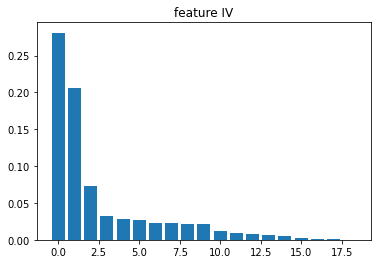

In [43]:
import matplotlib.pyplot as plt

'''
第四步：WOE编码、计算IV
'''
WOE_dict = {}
IV_dict = {}
# 分箱后的变量进行编码，包括：
# 1，初始取值个数小于5，且不需要合并的类别型变量。存放在less_value_features中
# 2，初始取值个数小于5，需要合并的类别型变量。合并后新的变量存放在var_bin_list中
# 3，初始取值个数超过5，需要合并的类别型变量。合并后新的变量存放在var_bin_list中
# 4，连续变量。分箱后新的变量存放在var_bin_list中
all_var = var_bin_list  + less_value_features
for var in all_var:
    woe_iv = CalcWOE(trainData, var, 'y')
    WOE_dict[var] = woe_iv['WOE']
    IV_dict[var] = woe_iv['IV']

# file4 = open('WOE_dict.pkl','w')
# pickle.dump(WOE_dict,file4)
# file4.close()

#将变量IV值进行降序排列，方便后续挑选变量
IV_dict_sorted = sorted(IV_dict.items(), key=lambda x: x[1], reverse=True)
IV_values = [i[1] for i in IV_dict_sorted]
IV_name = [i[0] for i in IV_dict_sorted]
plt.title('feature IV')
plt.bar(range(len(IV_values)),IV_values)

## 第五步：单变量分析和多变量分析，均基于WOE编码后的值。
（1）选择IV高于0.01的变量

（2）比较两两线性相关性。如果相关系数的绝对值高于阈值，剔除IV较低的一个


1.0787330506381618


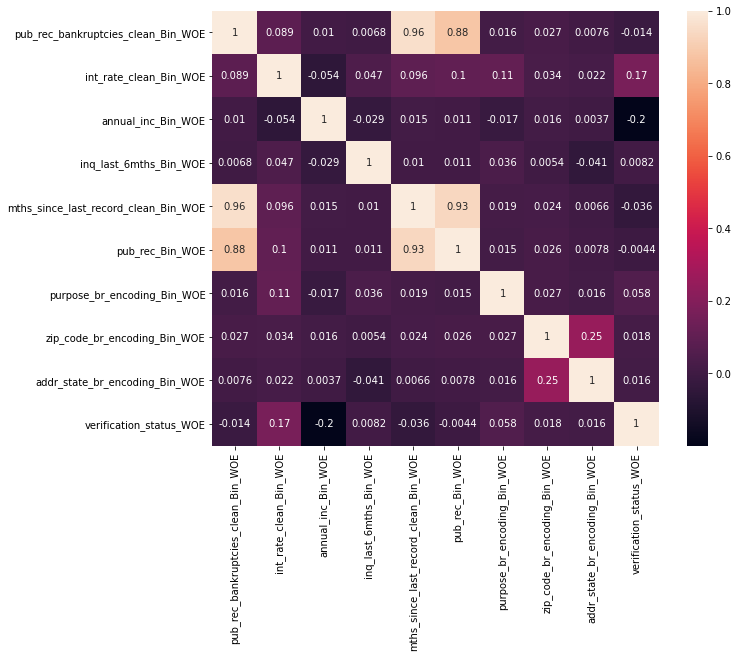

In [47]:
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor


#选取IV>0.01的变量
high_IV = {k:v for k, v in IV_dict.items() if v >= 0.02}
high_IV_sorted = sorted(high_IV.items(),key=lambda x:x[1],reverse=True)

short_list = high_IV.keys()
short_list_2 = []
for var in short_list:
    newVar = var + '_WOE'
    trainData[newVar] = trainData[var].map(WOE_dict[var])
    short_list_2.append(newVar)

#对于上一步的结果，计算相关系数矩阵，并画出热力图进行数据可视化
trainDataWOE = trainData[short_list_2]
f, ax = plt.subplots(figsize=(10, 8))
corr = trainDataWOE.corr()
#sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),square=True, ax=ax)
sns.heatmap(corr,annot=True)


#两两间的线性相关性检验
#1，将候选变量按照IV进行降序排列
#2，计算第i和第i+1的变量的线性相关系数
#3，对于系数超过阈值的两个变量，剔除IV较低的一个
deleted_index = []
cnt_vars = len(high_IV_sorted)
for i in range(cnt_vars):
    if i in deleted_index:
        continue
    x1 = high_IV_sorted[i][0]+"_WOE"
    for j in range(cnt_vars):
        if i == j or j in deleted_index:
            continue
        y1 = high_IV_sorted[j][0]+"_WOE"
        roh = np.corrcoef(trainData[x1],trainData[y1])[0,1]
        if abs(roh)>0.7:
            x1_IV = high_IV_sorted[i][1]
            y1_IV = high_IV_sorted[j][1]
            if x1_IV > y1_IV:
                deleted_index.append(j)
            else:
                deleted_index.append(i)

multi_analysis_vars_1 = [high_IV_sorted[i][0]+"_WOE" for i in range(cnt_vars) if i not in deleted_index]

'''
多变量分析：VIF
'''
X = np.matrix(trainData[multi_analysis_vars_1])
VIF_list = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
max_VIF = max(VIF_list)
print (max_VIF)
# 最大的VIF是1.32267733123，因此这一步认为没有多重共线性
multi_analysis = multi_analysis_vars_1




## 第六步：逻辑回归模型。
要求：
1，变量显著
2，符号为负


In [51]:
import statsmodels.api as sm
from sklearn.ensemble import RandomForestClassifier

### (1)将多变量分析的后变量带入LR模型中
y = trainData['y']
X = trainData[multi_analysis]
X['intercept'] = [1]*X.shape[0]


LR = sm.Logit(y, X).fit()
summary = LR.summary()
pvals = LR.pvalues
pvals = pvals.to_dict()

### 有些变量不显著，需要逐步剔除
varLargeP = {k: v for k,v in pvals.items() if v >= 0.1}
varLargeP = sorted(varLargeP.items(), key=lambda d:d[1], reverse = True)
while(len(varLargeP) > 0 and len(multi_analysis) > 0):
    # 每次迭代中，剔除最不显著的变量，直到
    # (1) 剩余所有变量均显著
    # (2) 没有特征可选
    varMaxP = varLargeP[0][0]
    print (varMaxP)
    if varMaxP == 'intercept':
        print ('the intercept is not significant!')
        break
    multi_analysis.remove(varMaxP)
    y = trainData['y']
    X = trainData[multi_analysis]
    X['intercept'] = [1] * X.shape[0]

    LR = sm.Logit(y, X).fit()
    #summary = LR.summary()
    pvals = LR.pvalues
    pvals = pvals.to_dict()
    varLargeP = {k: v for k, v in pvals.items() if v >= 0.1}
    varLargeP = sorted(varLargeP.items(), key=lambda d: d[1], reverse=True)

'''
int_rate_clean_Bin_WOE                 -0.923325
zip_code_br_encoding_Bin_WOE           -0.913290
purpose_br_encoding_Bin_WOE            -0.842351
annual_inc_Bin_WOE                     -0.778415
inq_last_6mths_Bin_WOE                 -0.871196
addr_state_br_encoding_Bin_WOE         -0.618244
mths_since_last_record_clean_Bin_WOE   -0.740668
emp_length_clean_Bin_WOE               -0.702146
home_ownership_Bin_WOE                 -0.396530
dti_Bin_WOE                            -0.709372
intercept                              -2.095788
'''
#
#
# saveModel =open(folderOfData+'LR_Model_Normal.pkl','w')
# pickle.dump(LR,saveModel)
# saveModel.close()
#
#


#尝试用L1约束#
## use cross validation to select the best regularization parameter
# multi_analysis = multi_analysis_vars_1
# X = trainData[multi_analysis]   #by default  LogisticRegressionCV() fill fit the intercept
# X = np.matrix(X)
# y = trainData['y']
# y = np.array(y)
#
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
# X_train.shape, y_train.shape
# #
# model_parameter = {}
# for C_penalty in np.arange(0.005, 0.2,0.005):
#     for bad_weight in range(2, 101, 2):
#         print C_penalty, bad_weight
#         LR_model_2 = LogisticRegressionCV(Cs=[C_penalty], penalty='l1', solver='liblinear', class_weight={1:bad_weight, 0:1})
#         LR_model_2_fit = LR_model_2.fit(X_train,y_train)
#         y_pred = LR_model_2_fit.predict_proba(X_test)[:,1]
#         scorecard_result = pd.DataFrame({'prob':y_pred, 'target':y_test})
#         performance = KS_AR(scorecard_result,'prob','target')
#         KS = performance['KS']
#         model_parameter[(C_penalty, bad_weight)] = KS

# endtime = datetime.datetime.now()
# print (endtime - starttime).seconds



# 用随机森林法估计变量重要性#
#
var_WOE_list = multi_analysis_vars_1
X = trainData[var_WOE_list]
X = np.matrix(X)
y = trainData['y']
y = np.array(y)

RFC = RandomForestClassifier()
RFC_Model = RFC.fit(X,y)
features_rfc = trainData[var_WOE_list].columns
featureImportance = {features_rfc[i]:RFC_Model.feature_importances_[i] for i in range(len(features_rfc))}
featureImportanceSorted = sorted(featureImportance.items(),key=lambda x: x[1], reverse=True)
# we selecte the top 10 features
features_selection = [k[0] for k in featureImportanceSorted[:8]]

y = trainData['y']
X = trainData[features_selection]
X['intercept'] = [1]*X.shape[0]


LR = sm.Logit(y, X).fit()
summary = LR.summary()

Optimization terminated successfully.
         Current function value: 0.375133
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.375133
         Iterations 7


In [52]:
### 计算KS值
def KS(df, score, target):
    '''
    :param df: 包含目标变量与预测值的数据集
    :param score: 得分或者概率
    :param target: 目标变量
    :return: KS值
    '''
    total = df.groupby([score])[target].count()
    bad = df.groupby([score])[target].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['good'] = all['total'] - all['bad']
    all[score] = all.index
    all = all.sort_values(by=score,ascending=False)
    all.index = range(len(all))
    all['badCumRate'] = all['bad'].cumsum() / all['bad'].sum()
    all['goodCumRate'] = all['good'].cumsum() / all['good'].sum()
    KS = all.apply(lambda x: x.badCumRate - x.goodCumRate, axis=1)
    return max(KS)
### Calculate the KS and AR for the socrecard model
def KS_AR(df, score, target):
    '''
    :param df: the dataset containing probability and bad indicator
    :param score:
    :param target:
    :return:
    '''
    total = df.groupby([score])[target].count()
    bad = df.groupby([score])[target].sum()
    all = pd.DataFrame({'total':total, 'bad':bad})
    all['good'] = all['total'] - all['bad']
    all[score] = all.index
    all = all.sort_values(by=score,ascending=False)
    all.index = range(len(all))
    all['badCumRate'] = all['bad'].cumsum() / all['bad'].sum()
    all['goodCumRate'] = all['good'].cumsum() / all['good'].sum()
    all['totalPcnt'] = all['total'] / all['total'].sum()
    arList = [0.5 * all.loc[0, 'badCumRate'] * all.loc[0, 'totalPcnt']]
    for j in range(1, len(all)):
        ar0 = 0.5 * sum(all.loc[j - 1:j, 'badCumRate']) * all.loc[j, 'totalPcnt']
        arList.append(ar0)
    arIndex = (2 * sum(arList) - 1) / (all['good'].sum() * 1.0 / all['total'].sum())
    KS = all.apply(lambda x: x.badCumRate - x.goodCumRate, axis=1)
    return {'AR':arIndex, 'KS': max(KS)}


In [54]:
#############################################################################################################
#尝试用L1约束#
## use cross validation to select the best regularization parameter
# multi_analysis = multi_analysis_vars_1
# X = trainData[multi_analysis]   #by default  LogisticRegressionCV() fill fit the intercept
# X = np.matrix(X)
# y = trainData['y']
# y = np.array(y)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)
# X_train.shape, y_train.shape
# #
# model_parameter = {}
# for C_penalty in np.arange(0.005, 0.2,0.005):
#     for bad_weight in range(2, 101, 2):
#         print (C_penalty, bad_weight)
#         LR_model_2 = LogisticRegressionCV(Cs=[C_penalty], penalty='l1', solver='liblinear', class_weight={1:bad_weight, 0:1})
#         LR_model_2_fit = LR_model_2.fit(X_train,y_train)
#         y_pred = LR_model_2_fit.predict_proba(X_test)[:,1]
#         scorecard_result = pd.DataFrame({'prob':y_pred, 'target':y_test})
#         performance = KS_AR(scorecard_result,'prob','target')
#         KS = performance['KS']
#         model_parameter[(C_penalty, bad_weight)] = KS

# endtime = datetime.datetime.now()
# print (endtime - starttime).seconds



# 用随机森林法估计变量重要性#
#
var_WOE_list = multi_analysis_vars_1
X = trainData[var_WOE_list]
X = np.matrix(X)
y = trainData['y']
y = np.array(y)

RFC = RandomForestClassifier()
RFC_Model = RFC.fit(X,y)
features_rfc = trainData[var_WOE_list].columns
featureImportance = {features_rfc[i]:RFC_Model.feature_importances_[i] for i in range(len(features_rfc))}
featureImportanceSorted = sorted(featureImportance.items(),key=lambda x: x[1], reverse=True)
# we selecte the top 10 features
features_selection = [k[0] for k in featureImportanceSorted[:8]]

y = trainData['y']
X = trainData[features_selection]
X['intercept'] = [1]*X.shape[0]


LR = sm.Logit(y, X).fit()
summary = LR.summary()



Optimization terminated successfully.
         Current function value: 0.375133
         Iterations 7
